## Get dataset

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

In [2]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/dataset'

Mounted at /content/drive
test  train  val


In [11]:
# path = '/content/drive/MyDrive/dataset'
path = 'dataset'

## Settings

In [12]:
seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [13]:
# Settings
data_dir = path

batch_size = 32
num_epochs = 30
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Device: {device}")

[+] Device: cpu


## Pre - processing

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [15]:
# Load the datasets with ImageFolder
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}


In [16]:
# DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True if x == 'train' else False, num_workers=4)
    for x in ['train', 'val', 'test']
}

## Architecture

In [29]:
# Class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [30]:
# Load a pre-trained model
model = models.resnet50(pretrained=True)

# Modify the last layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [32]:
# Function to train the model and return the best model
def train_model(model, dataloaders, criterion, optimizer, num_epochs: int):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} Phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Reset gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"Best val Acc: {best_acc:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Test Phase"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(dataloader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

In [36]:
model = train_model(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.09it/s]


train Loss: 0.0550 Acc: 0.9832


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]


val Loss: 0.4272 Acc: 0.9163
Epoch 2/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.09it/s]


train Loss: 0.0862 Acc: 0.9727


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s]


val Loss: 0.4496 Acc: 0.9019
Epoch 3/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.1372 Acc: 0.9574


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]


val Loss: 0.3921 Acc: 0.9139
Epoch 4/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.09it/s]


train Loss: 0.0659 Acc: 0.9796


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


val Loss: 0.5262 Acc: 0.8900
Epoch 5/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.0713 Acc: 0.9781


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]


val Loss: 0.5303 Acc: 0.8660
Epoch 6/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.1925 Acc: 0.9401


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


val Loss: 0.4027 Acc: 0.9139
Epoch 7/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0845 Acc: 0.9709


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.43it/s]


val Loss: 0.4125 Acc: 0.9043
Epoch 8/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.1057 Acc: 0.9658


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.29it/s]


val Loss: 0.2489 Acc: 0.9498
Epoch 9/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


train Loss: 0.0549 Acc: 0.9829


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s]


val Loss: 0.3798 Acc: 0.9187
Epoch 10/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.12it/s]


train Loss: 0.0620 Acc: 0.9799


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


val Loss: 0.3736 Acc: 0.9187
Epoch 11/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.08it/s]


train Loss: 0.0862 Acc: 0.9730


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.44it/s]


val Loss: 0.2885 Acc: 0.9402
Epoch 12/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0425 Acc: 0.9889


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


val Loss: 0.3119 Acc: 0.9402
Epoch 13/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


train Loss: 0.0826 Acc: 0.9727


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.42it/s]


val Loss: 0.4400 Acc: 0.8947
Epoch 14/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.09it/s]


train Loss: 0.0603 Acc: 0.9775


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.39it/s]


val Loss: 0.3763 Acc: 0.9234
Epoch 15/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.05it/s]


train Loss: 0.0897 Acc: 0.9724


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


val Loss: 0.6720 Acc: 0.8517
Epoch 16/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.09it/s]


train Loss: 0.0859 Acc: 0.9748


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]


val Loss: 0.5733 Acc: 0.8876
Epoch 17/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


train Loss: 0.0454 Acc: 0.9859


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.48it/s]


val Loss: 0.3700 Acc: 0.9211
Epoch 18/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.0568 Acc: 0.9814


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]


val Loss: 0.3127 Acc: 0.9306
Epoch 19/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


train Loss: 0.1238 Acc: 0.9640


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.64it/s]


val Loss: 0.2729 Acc: 0.9306
Epoch 20/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0270 Acc: 0.9931


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]


val Loss: 0.2174 Acc: 0.9450
Epoch 21/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.09it/s]


train Loss: 0.0227 Acc: 0.9925


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


val Loss: 0.2626 Acc: 0.9330
Epoch 22/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.0385 Acc: 0.9856


val Phase: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]


val Loss: 0.2877 Acc: 0.9306
Epoch 23/30


train Phase: 100%|██████████| 105/105 [00:34<00:00,  3.05it/s]


train Loss: 0.0416 Acc: 0.9856


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.28it/s]


val Loss: 0.3860 Acc: 0.9234
Epoch 24/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0565 Acc: 0.9820


val Phase: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


val Loss: 0.3618 Acc: 0.9211
Epoch 25/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0851 Acc: 0.9691


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


val Loss: 0.3414 Acc: 0.9306
Epoch 26/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.0854 Acc: 0.9724


val Phase: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


val Loss: 0.3028 Acc: 0.9258
Epoch 27/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]


train Loss: 0.1410 Acc: 0.9559


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.76it/s]


val Loss: 0.4362 Acc: 0.8971
Epoch 28/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0502 Acc: 0.9823


val Phase: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


val Loss: 0.4876 Acc: 0.9139
Epoch 29/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0561 Acc: 0.9847


val Phase: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s]


val Loss: 0.3160 Acc: 0.9187
Epoch 30/30


train Phase: 100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


train Loss: 0.0199 Acc: 0.9928


val Phase: 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

val Loss: 0.4217 Acc: 0.9091
Best val Acc: 0.9498


In [37]:
# Save model
torch.save(model.state_dict(), f'{path}/face_class_model.pth')

In [38]:
test_model(model, dataloaders['test'])

Test Phase: 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]

Test Accuracy: 0.9464


## Testing model

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image

In [7]:
import os

image_path = os.path.join(os.getcwd(), 'dataset', 'test', 'armando_garcia', 'armando_garcia_3.jpg')
model_path = os.path.join(os.getcwd(), 'models', 'face_class_model.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Transformaciones (iguales a las usadas en 'test')
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar la imagen
    transforms.ToTensor(),         # Convertir la imagen a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar
])

In [4]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Transform to RGB
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor


def load_model(path, num_classes):
    model = models.resnet50(pretrained=False)                      
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))    # Load weights
    model = model.to(device)                                        # Send to GPU or CPU
    model.eval()
    return model


def predict_image(model, image_tensor, class_names):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)
    return class_names[predicted_class.item()]

In [5]:
class_names = os.listdir(os.path.join(os.getcwd(), 'dataset', 'test'))

In [8]:
# Load the image and preprocess it
input_tensor = preprocess_image(image_path)

# Load the model
model = load_model(model_path, num_classes=len(class_names))

# Get the prediction
prediction = predict_image(model, input_tensor, class_names)

# Show the prediction
print(f"La predicción para la imagen es: {prediction}")

c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\Semestres\9no\Mineria\face_class\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uriel\OneDrive\Escritorio\Uriel\IPN\ESCOM\Semestres\9no\Mineria\face_class\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\uriel\AppData\Local\Temp\ipykernel_13508\3838823375.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

La predicción para la imagen es: armando_garcia


## Assessment

In [17]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

# Usar con el conjunto de prueba:
calculate_accuracy(model, dataloaders['test'])


Accuracy: 0.9464


array([[18,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0,  0, 

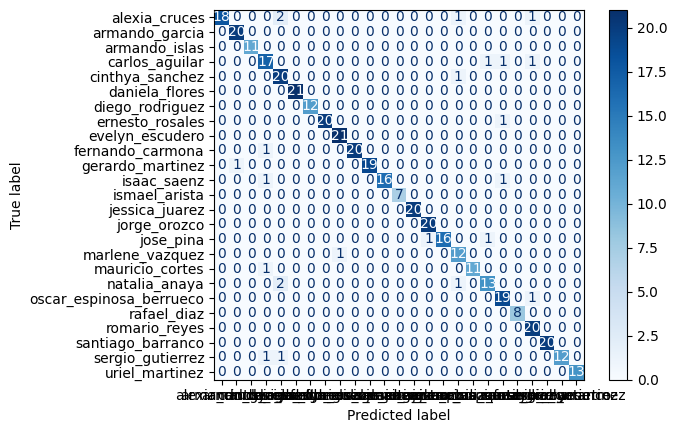

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names):
    all_labels = []
    all_preds = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    return cm

# Llamar a la función
plot_confusion_matrix(model, dataloaders['test'], class_names)


In [25]:
from sklearn.metrics import classification_report

def evaluate_classification_report(model, dataloader, class_names):
    all_labels = []
    all_preds = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

# Llamar a la función
evaluate_classification_report(model, dataloaders['test'], class_names)


                         precision    recall  f1-score   support

          alexia_cruces       1.00      0.82      0.90        22
         armando_garcia       0.95      1.00      0.98        20
          armando_islas       1.00      1.00      1.00        11
         carlos_aguilar       0.81      0.85      0.83        20
        cinthya_sanchez       0.80      0.95      0.87        21
         daniela_flores       1.00      1.00      1.00        21
        diego_rodriguez       1.00      1.00      1.00        12
        ernesto_rosales       1.00      0.95      0.98        21
        evelyn_escudero       0.95      1.00      0.98        21
       fernando_carmona       1.00      0.95      0.98        21
       gerardo_martinez       1.00      0.95      0.97        20
            isaac_saenz       1.00      0.89      0.94        18
          ismael_arista       1.00      1.00      1.00         7
         jessica_juarez       1.00      1.00      1.00        20
           jorge_orozco 